# Modelling

### Libraries

In [16]:
# import libraries

import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

### Data

In [17]:
# load review sentiment data

review_df = pd.read_csv('data/review_sentiment.csv')

review_df

,review_id,text,sentiment
0,LLzom-2TITa4gasV7_fCCA,Great experience purchasing a washer and dryer...,1
1,a5JHzBrWxRd_OmIvV7znDA,Went here based on the high ratings and raves ...,-1
2,X-o--dwf0HuFMittYi4wCA,"oh Millers, how i wanted to like you. You are...",-1
3,INGNbsyo-MouZZzcxnCSGQ,This place gets two stars from me only because...,-1
4,k7VatXVLism-cTDJE8TTUw,"This place was awesome. Clean, beautiful and t...",1
...,...,...,...
11681,IlU-MQzMKc7jAHWwK5VFGQ,"To be fair, I tried them in their first week. ...",0
11682,Qt3BsRvQuJccDQfFWM1XPw,Awful place. It's dirty. Had two birthday part...,-1
11683,3CQQ8Im_UX6QqDECuXYK8A,A truly vegetarian delight! I took a Jewish f...,1
11684,ery1nBM7zKweFLBe-bT5ag,I have a 2011 Toyota Sienna Limited. During th...,-1


Load matrix

In [18]:
feature_set = {
    0: 'bag_of_words',
    1: 'one_hot',
    2: 'n_grams',
    3: 'tf_idf',
    4: 'word2vec',
    5: 'combined_bow_negation'
}
# Load all feature sets
features = {}
for key, feature_name in feature_set.items():
    if key == 4:
        features[key] = np.load('features/' + feature_name + '.npy')
    else:
        features[key] = sparse.load_npz('features/' + feature_name + '.npz')

In [4]:
# target labels

y = review_df['sentiment'].to_numpy()

y.shape

(11686,)

Classifiers

In [5]:
# classifiers

classifiers = {
    'gaussian_nb': GaussianNB(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'svm': SVC(),
    'perceptron': Perceptron(tol=1e-3, random_state=0),
    'xgb': XGBClassifier(),
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=0)
}

In [6]:
param_grids = {
    'decision_tree': {
        'max_depth': [None, 10, 20]
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10]
    },
    'svm': {
        'C': [0.1, 1.0],
        'kernel': ['linear', 'rbf']
    },
    'perceptron': {
        'alpha': [0.0001, 0.001],
        'penalty': [None, 'l2']
    },
    'xgb': {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200]
    },
    'logistic_regression': {
        'C': [0.1, 1.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
}


In [7]:
# Load word2vec features for grid search
word2vec_features = features[4]


In [8]:
# Split data into training and test sets using word2vec features
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(word2vec_features, y, test_size=0.20, random_state=42)

# oversampler = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_w2v, y_train)


In [9]:
# xgb algorithm expects [0 1 2], not [-1 0 1]

# Convert numpy arrays to pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Remap labels: -1 -> 0, 0 -> 1, 1 -> 2
y_train_mapped = y_train_series.map({-1: 0, 0: 1, 1: 2})
y_test_mapped = y_test_series.map({-1: 0, 0: 1, 1: 2})

Grid search with cross validation

In [10]:
best_estimators = {}
grid_results = []

# Apply grid search to each classifier using word2vec features
for clf_name, clf in classifiers.items():
    print(f"Grid search for {clf_name}")
    param_grid = param_grids[clf_name]
    if clf_name == 'xgb':
        grid_search = GridSearchCV(clf, param_grid, scoring='f1_weighted', cv=5)
        grid_search.fit(X_train_w2v, y_train_mapped)
    else:
        grid_search = GridSearchCV(clf, param_grid, scoring='f1_weighted', cv=5)
        grid_search.fit(X_train_w2v, y_train)
    best_estimators[clf_name] = grid_search.best_estimator_
    grid_results.append({
        'classifier': clf_name,
        'best_parameters': grid_search.best_params_,
        'best_f1': grid_search.best_score_,
    })
    print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
    print(f"Best score for {clf_name}: {grid_search.best_score_}")
    print("---------------------------------------------")

grid_results_df = pd.DataFrame(grid_results)
grid_results_df.to_csv('grid_results.csv', index=False)


Grid search for gaussian_nb
Best parameters for gaussian_nb: {}
Best score for gaussian_nb: 0.5065980589216799
---------------------------------------------
Grid search for decision_tree
Best parameters for decision_tree: {'max_depth': 10}
Best score for decision_tree: 0.5306139337130708
---------------------------------------------
Grid search for random_forest
Best parameters for random_forest: {'max_depth': None, 'n_estimators': 200}
Best score for random_forest: 0.623274152507785
---------------------------------------------
Grid search for svm
Best parameters for svm: {'C': 1.0, 'kernel': 'rbf'}
Best score for svm: 0.7215333767954311
---------------------------------------------
Grid search for perceptron
Best parameters for perceptron: {'alpha': 0.0001, 'penalty': None}
Best score for perceptron: 0.7033121484291686
---------------------------------------------
Grid search for xgb
Best parameters for xgb: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best score for x

In [14]:
best_estimators = {
    'multinomial_nb': MultinomialNB(),
    'xgb': XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200),
    'decision_tree': DecisionTreeClassifier(max_depth=10),
    'random_forest': RandomForestClassifier(max_depth=None, n_estimators=200),
    'svm': SVC(C=1.0, kernel='rbf'),
    'perceptron': Perceptron(tol=1e-3, random_state=0, alpha=0.0001, penalty=None),
    'logistic_regression': LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000)
}

Train and evaluate all models for all feature sets

In [15]:
from sklearn.metrics import accuracy_score

results = []

# Loop through each feature set
for feature_key, feature_name in feature_set.items():

    X_train, X_test, y_train, y_test = train_test_split(features[feature_key], y, test_size=0.20, random_state=42)

    # Oversample to balance the classes
    # oversampler = RandomOverSampler(random_state=42)
    # X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    
    # change -1 to 2 because of xbg
    y_train_series = pd.Series(y_train)
    y_test_series = pd.Series(y_test)
    y_train_mapped = y_train_series.map({-1: 0, 0: 1, 1: 2})
    y_test_mapped = y_test_series.map({-1: 0, 0: 1, 1: 2})


    print(f"Using {feature_name} features:")
    
    # Loop through each classifier
    for clf_name, clf in best_estimators.items():
        print(f"Training {clf_name} with {feature_name} features...")   
        
        if clf_name == 'multinomial_nb' and feature_key == 4:
            print(f"Skipping {clf_name} with {feature_name} features due to negative values or unsuitable feature type.")
            continue
        # Convert sparse to dense if necessary
        if feature_key != 4 and clf_name in ['gaussian_nb', 'multinomial_nb', 'perceptron']:
            X_train_dense = X_train.toarray()
            X_test_dense = X_test.toarray()
            clf.fit(X_train_dense, y_train)
            y_pred = clf.predict(X_test_dense)
        else:
            if clf_name == 'xgb':
                clf.fit(X_train, y_train_mapped)
            else:
                clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
        
        # Evaluate
        if clf_name == 'xgb':
            acc = accuracy_score(y_test_mapped, y_pred)
            precision = precision_score(y_test_mapped, y_pred, average='macro')
            recall = recall_score(y_test_mapped, y_pred, average='macro')
            f1 = f1_score(y_test_mapped, y_pred, average='macro')
        else:
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"Precision of {clf_name} with {feature_name} features: {precision}")
        print(f"Recall of {clf_name} with {feature_name} features: {recall}")
        print(f"F1 Score of {clf_name} with {feature_name} features: {f1}")
        print(f"Accuracy of {clf_name} with {feature_name} features: {acc}")
            
    # Append the results to the list
        results.append({
            'feature_set': feature_name,
            'classifier': clf_name,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': acc
        })
        print("--------------------------------------")

    print("-------------------------------------------------------------------")


Using bag_of_words features:
Training multinomial_nb with bag_of_words features...
Precision of multinomial_nb with bag_of_words features: 0.6607395889655369
Recall of multinomial_nb with bag_of_words features: 0.6411506150757784
F1 Score of multinomial_nb with bag_of_words features: 0.6438441506749296
Accuracy of multinomial_nb with bag_of_words features: 0.7976903336184773
--------------------------------------
Training xgb with bag_of_words features...
Precision of xgb with bag_of_words features: 0.7424430262446066
Recall of xgb with bag_of_words features: 0.6458782998812872
F1 Score of xgb with bag_of_words features: 0.6495154640549461
Accuracy of xgb with bag_of_words features: 0.8122326775021386
--------------------------------------
Training decision_tree with bag_of_words features...
Precision of decision_tree with bag_of_words features: 0.5579153751762319
Recall of decision_tree with bag_of_words features: 0.5260026364165876
F1 Score of decision_tree with bag_of_words features

c:\Users\bruna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision of multinomial_nb with tf_idf features: 0.5447854105522766
Recall of multinomial_nb with tf_idf features: 0.5905827918319712
F1 Score of multinomial_nb with tf_idf features: 0.5622180475094294
Accuracy of multinomial_nb with tf_idf features: 0.7946963216424294
--------------------------------------
Training xgb with tf_idf features...
Precision of xgb with tf_idf features: 0.7401572460207285
Recall of xgb with tf_idf features: 0.6488583808765714
F1 Score of xgb with tf_idf features: 0.6511038845043191
Accuracy of xgb with tf_idf features: 0.8143712574850299
--------------------------------------
Training decision_tree with tf_idf features...
Precision of decision_tree with tf_idf features: 0.6001096491228071
Recall of decision_tree with tf_idf features: 0.5416411111851084
F1 Score of decision_tree with tf_idf features: 0.5240468616156232
Accuracy of decision_tree with tf_idf features: 0.693327630453379
--------------------------------------
Training random_forest with tf_idf 

c:\Users\bruna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision of svm with lsa_topic_matrix features: 0.4482677394960919
Recall of svm with lsa_topic_matrix features: 0.4906763455079964
F1 Score of svm with lsa_topic_matrix features: 0.46457438832341413
Accuracy of svm with lsa_topic_matrix features: 0.6659538066723696
--------------------------------------
Training perceptron with lsa_topic_matrix features...
Precision of perceptron with lsa_topic_matrix features: 0.42667303796437067
Recall of perceptron with lsa_topic_matrix features: 0.4422297065163043
F1 Score of perceptron with lsa_topic_matrix features: 0.41879524370686066
Accuracy of perceptron with lsa_topic_matrix features: 0.5585970915312233
--------------------------------------
Training logistic_regression with lsa_topic_matrix features...
Precision of logistic_regression with lsa_topic_matrix features: 0.5824204955526814
Recall of logistic_regression with lsa_topic_matrix features: 0.4862794284451802
F1 Score of logistic_regression with lsa_topic_matrix features: 0.463657911

c:\Users\bruna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bruna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bruna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [1]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('classification_results.csv', index=False)

NameError: name 'pd' is not defined

Unsupervised

In [11]:
# VADER sentiment analysis

vader = SentimentIntensityAnalyzer()
res = []
y_pred_vader = []
for review in review_df['text']:
    sentiment = vader.polarity_scores(review)
    res.append(sentiment)
    pred = round(sentiment['compound'])
    y_pred_vader.append(pred)

res

[{'neg': 0.045, 'neu': 0.762, 'pos': 0.193, 'compound': 0.9762},
 {'neg': 0.063, 'neu': 0.891, 'pos': 0.046, 'compound': -0.4508},
 {'neg': 0.049, 'neu': 0.842, 'pos': 0.109, 'compound': 0.979},
 {'neg': 0.133, 'neu': 0.793, 'pos': 0.074, 'compound': -0.566},
 {'neg': 0.0, 'neu': 0.542, 'pos': 0.458, 'compound': 0.9871},
 {'neg': 0.086, 'neu': 0.881, 'pos': 0.034, 'compound': -0.6124},
 {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.9808},
 {'neg': 0.0, 'neu': 0.751, 'pos': 0.249, 'compound': 0.807},
 {'neg': 0.096, 'neu': 0.786, 'pos': 0.117, 'compound': 0.4547},
 {'neg': 0.029, 'neu': 0.812, 'pos': 0.159, 'compound': 0.9728},
 {'neg': 0.015, 'neu': 0.901, 'pos': 0.085, 'compound': 0.8786},
 {'neg': 0.023, 'neu': 0.901, 'pos': 0.076, 'compound': 0.9761},
 {'neg': 0.021, 'neu': 0.615, 'pos': 0.364, 'compound': 0.9858},
 {'neg': 0.0, 'neu': 0.799, 'pos': 0.201, 'compound': 0.8775},
 {'neg': 0.0, 'neu': 0.592, 'pos': 0.408, 'compound': 0.9803},
 {'neg': 0.0, 'neu': 0.583, 'pos': 

In [12]:
# performance metrics - VADER

y_true = review_df['sentiment']
y_true = y_true.values

In [13]:
cm = confusion_matrix(y_true, y_pred_vader)
accuracy = accuracy_score(y_true, y_pred_vader)
precision = precision_score(y_true, y_pred_vader, average='weighted')
recall = recall_score(y_true, y_pred_vader, average='weighted')
f1 = f1_score(y_true, y_pred_vader, average='weighted')
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Confusion Matrix:
[[1887 1305 1299]
 [  90  267  910]
 [  52  332 5544]]
Accuracy: 0.6587369501968167
Precision: 0.7353544226999599
Recall: 0.6587369501968167
F1-score: 0.651836225229989


In [14]:
# dataframe with VADER sentiment scores

vader_df = pd.DataFrame(res)
vader_df = vader_df['compound']
vader_df = pd.concat([review_df, vader_df], axis=1)

vader_df

,review_id,text,sentiment,compound
0,LLzom-2TITa4gasV7_fCCA,Great experience purchasing a washer and dryer...,1,0.9762
1,a5JHzBrWxRd_OmIvV7znDA,Went here based on the high ratings and raves ...,-1,-0.4508
2,X-o--dwf0HuFMittYi4wCA,"oh Millers, how i wanted to like you. You are...",-1,0.9790
3,INGNbsyo-MouZZzcxnCSGQ,This place gets two stars from me only because...,-1,-0.5660
4,k7VatXVLism-cTDJE8TTUw,"This place was awesome. Clean, beautiful and t...",1,0.9871
...,...,...,...,...
11681,IlU-MQzMKc7jAHWwK5VFGQ,"To be fair, I tried them in their first week. ...",0,0.8462
11682,Qt3BsRvQuJccDQfFWM1XPw,Awful place. It's dirty. Had two birthday part...,-1,0.5896
11683,3CQQ8Im_UX6QqDECuXYK8A,A truly vegetarian delight! I took a Jewish f...,1,0.9884
11684,ery1nBM7zKweFLBe-bT5ag,I have a 2011 Toyota Sienna Limited. During th...,-1,-0.8859


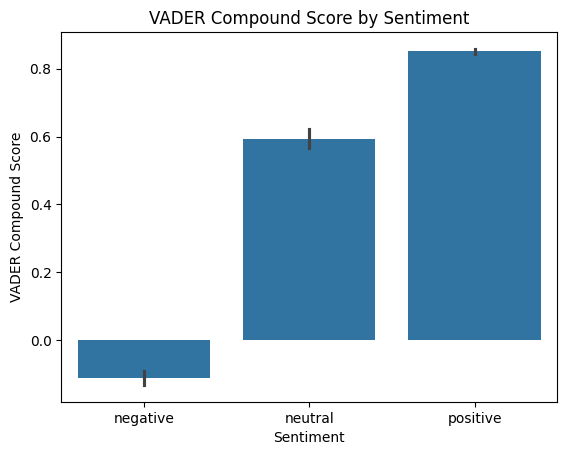

In [15]:
# visualize VADER compound scores by sentiment

negative_scores = vader_df[vader_df['sentiment'] == -1]['compound']
neutral_scores = vader_df[vader_df['sentiment'] == 0]['compound']
positive_scores = vader_df[vader_df['sentiment'] == 1]['compound']
all_scores = pd.concat([negative_scores, neutral_scores, positive_scores])

sentiments = ['negative'] * len(negative_scores) + ['neutral'] * len(neutral_scores) + ['positive'] * len(positive_scores)
sentiment_scores = pd.DataFrame({'sentiment': sentiments, 'compound': all_scores})

sns.barplot(data=sentiment_scores, x='sentiment', y='compound')
plt.xlabel('Sentiment')
plt.ylabel('VADER Compound Score')
plt.title('VADER Compound Score by Sentiment')
plt.show()